In [5]:
import numpy as np


class CoinEnv:
    def __init__(self, start_price=1000, avr_m=0.5):
        self.action_space = [np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1])]
        self.start_price = start_price
        self.history=[]
        self.bought_time=[]
        self.sold_time=[]
        self.avr_m=avr_m

    def reset(self):
        self.state = self.start_price
        return self.state

    def step(self, action, current_time):
        current_price = self.state
        if action[1] and len(self.history)<=30: # buy
            reward = -current_price
            self.history.append(current_price)
            self.bought_time.append(current_time)
        elif action[2] and len(self.history)!=0: # sell
            reward = current_price
            self.history.remove(min(self.history))
            self.sold_time.append(current_time)
        else:
            reward = 0

        direction = np.random.choice([-1, 1])
        current_price += direction
        current_price=max(0, current_price)
        self.state = current_price
        

        # print(self.history)

        return self.state, reward, False, {'history': self.history, 'bought_time': self.bought_time, 'sold_time': self.sold_time}
        

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RewardFunction(nn.Module):
    def __init__(self):
        super(RewardFunction, self).__init__()

    def forward(self, state, action, mask, done):
        current_price = state[0]
        inventory = state[1:]

        current_price = current_price.float()
        inventory = inventory.float()
        mask = mask.float()

        reward = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)

        if action[2] == 1:  # Sell action
            if mask.sum() > 0:  # We have something to sell
                valid_inventory = inventory * mask
                min_value, min_index = valid_inventory.min(dim=0, keepdim=True)
                reward += (current_price - min_value) * mask[min_index]

        if done:
            valid_inventory = inventory * mask
            while mask.sum() > 0:
                min_value, min_index = valid_inventory.min(dim=0, keepdim=True)
                reward += (current_price - min_value).sum()
                mask[min_index] = 0

        return reward

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Write neural network code => 저번에한거
class NeuralNetwork(nn.Module):
    #input_dim: 상태정보의 크기(현재가격 1+구매이력 10)
    #이때 구매이력의 크기는 최대구매가능횟수로 결정

    #output_dim: 행동의 크기(구매하기, 팔기, 기다리기 => 3가지)
    
    def __init__(self, input_dim=11, output_dim=3, hidden_dim=512, num_layers=3):
        super(NeuralNetwork, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = [
            nn.Linear(hidden_dim, hidden_dim)
            for _ in range(num_layers)
        ]
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation(x)
        for layer in self.hidden_layers:
          x = layer(x)
          x = self.activation(x)
        x = self.output_layer(x)
        return x

In [16]:
# 상태정보를 뉴럴넷이 처리할수있는 PyTorch Tensor로 변경
# 여기 환경코드는 구매 가능 빈 슬롯을 None으로 처리, 곧 아래 코드가 필요

def parse_state(state, start_price=10000, normalization_constant=10):
    current_price = np.array([state[0]])
    current_inventory = np.array(state[1:])

    # 마스크를 생성
    # 구매한 index는 1, 빈 index는 0을 출력

    mask = np.ones_like(current_inventory)
    mask_index = np.where(current_inventory == None)
    mask[mask_index] = 0
    mask = torch.tensor(mask.astype(np.float32)) # 텐서로 변경

    current_inventory[mask_index] = start_price
    state = np.concatenate([current_price, current_inventory])
    state = torch.tensor(state.astype(np.float32)) # 텐서로 변경
    state -= start_price
    state /= normalization_constant
    return state, mask

# 보상함수를 따로 정의
# 지도함수의 보상 함수(Loss Function))의 역할을 수행할 수 있도록 하기 위함
class RewardFunction(nn.Module):
    def __init__(self):
        super(RewardFunction, self).__init__()

    def forward(self, state, action, mask, done):
        current_price = state[0]
        inventory = state[1:]

        current_price = current_price.float()
        inventory = inventory.float()
        mask = mask.float()

        reward = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)

        if action[2] == 1:  # Sell action
            if mask.sum() > 0:  # We have something to sell
                valid_inventory = inventory * mask
                min_value, min_index = valid_inventory.min(dim=0, keepdim=True)
                reward += (current_price - min_value) * mask[min_index]

        if done:
            valid_inventory = inventory * mask
            while mask.sum() > 0:
                min_value, min_index = valid_inventory.min(dim=0, keepdim=True)
                reward += (current_price - min_value).sum()
                mask[min_index] = 0

        return reward

In [17]:
def train(num_epochs=100):

    model = NeuralNetwork() # 모델 정의
    reward_function = RewardFunction() # 보상함수 정의

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 뉴럴넷 학습을 위해 필요한부분

    for epoch in range(num_epochs):
        env = CoinEnv()
        state = env.reset()
        current_price = state[0]
        current_time = 0
        total_reward = 0
        done = False

        while not done:
            timeline.append(current_time)
            price_history.append(current_price)
            state, mask = parse_state(state)



            # optimizer.zero_qrad()
            # output = network(k)
            # loss = loss_function(y, output)
            # loss.backward()
            # optimizer.step()


            optimizer.zero_grad()

            logits = model(state) #(2)
            #logit은 모델이 선택하느 행동에 대한 확률
            # 가장 큰 선택을 하는 확률
            argmax_index = torch.argmax(logits)
            num_classes = logits.size(0)
            action = F.one_hot(argmax_index, num_classes)
            reward = reward_function(state, action, mask, done) # 3
            loss = -reward 

            reward.backward()
            optimizer.step()

            state, _, done, _ = env.step(action)# 4
            current_price = state[0] # 5
            current_time += 1
            total_reward += reward

        print(f"Total Reward: {total_reward}")

train()


c:\Users\repry\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TypeError: 'int' object is not subscriptable

0 -999 -998 999 -998 -997 -996 -997 998 -997 -996 -995 -994 -993 -994 -993 -992 -993 -992 -993 -994 -993 -992 -991 -992 -991 -992 -991 -990 -989 -990 -989 -990 -989 -990 -989 0 0 0 0 0 0 0 993 -992 993 994 995 996 995 994 995 994 -993 -992 -993 -992 -993 994 -993 994 -993 994 995 996 995 996 997 996 995 996 995 994 -993 994 -993 994 995 996 995 996 995 996 995 994 -993 -992 -991 -992 -993 994 -993 994 -993 994 995 996 995 994 995 994 -993 994 995 994 995 996 995 996 997 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

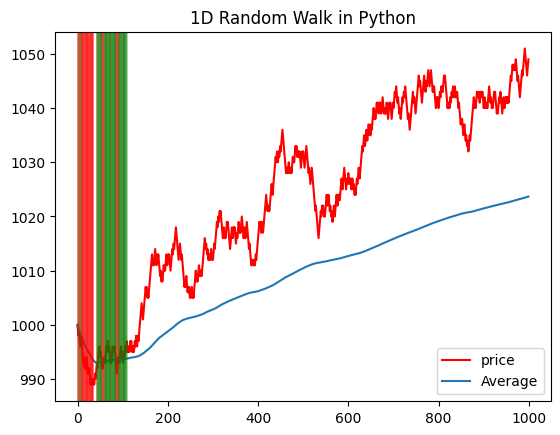

In [14]:
import matplotlib.pyplot as plt

total_total_reward=[]

timeline = []
price_history = []

env = CoinEnv(avr_m=0.1)
state = env.reset()
reward=0
current_time = 0
avr_history=[]
total_reward=[]

for _ in range(1000):
    timeline.append(current_time)
    price_history.append(state)
    # action = env.action_space[np.random.randint(3)]
    avr_history.append(np.mean(price_history))
    if state<np.mean(price_history):
        action = env.action_space[1]
    else:
        action = env.action_space[2]
    # action = env.action_space[0]
    state, reward, _, history = env.step(action, current_time)
    current_time += 1
    total_reward.append(reward)
for _ in env.history:
    total_reward.append(state)
print(" ".join(map(str, total_reward)))
print(f"avr: {np.mean(total_reward)}, max: {max(total_reward)}, min: {min(total_reward)}")

plt.plot(timeline, price_history, 'r-', label='price')
# plt.axhline(np.mean(price_history), label='Total Average')
plt.plot(timeline, avr_history, label='Average')
a,b=False,False
for i in history['bought_time']:
    plt.axvline(i, color='red', alpha=0.3)
for i in history['sold_time']:
    plt.axvline(i, color='green', alpha=0.3)
plt.legend()
plt.title("1D Random Walk in Python")
plt.show()

-1000 1001 -1000 -1001 1000 0 0 999 -998 -999 0 1001 0 -1001 0 -1003 0 -1001 1000 1001 1000 0 -1000 -999 1000 -1001 0 -999 0 -1001 0 -1003 0 0 0 -1001 0 -1001 1002 1001 1002 0 1002 -1001 1002 1001 -1002 -1001 1000 -999 1000 1001 1000 -1001 0 1001 -1000 0 -1000 -999 -998 -997 996 995 996 0 994 -995 -994 -993 0 995 994 0 -992 993 994 -995 0 -997 0 -997 -998 999 0 -999 0 0 0 -1001 -1002 1003 1004 1003 1002 -1003 1002 -1001 1000 999 -998 999 998 -997 996 -997 0 -997 -996 995 996 -997 0 0 1000 999 0 0 -998 -997 -998 -997 -996 997 0 0 996 995 994 0 996 -997 -996 -997 998 999 1000 -999 1000 -1001 -1000 1001 0 1001 -1002 1001 1002 0 1000 -999 0 999 -1000 0 1000 999 -998 997 0 0 -998 999 0 0 -1000 0 -1000 999 998 0 -998 -999 1000 1001 0 -1003 1004 -1005 -1004 -1003 -1004 1005 1006 0 1006 1005 -1004 0 -1002 -1003 0 -1001 1002 1001 1000 1001 -1000 0 1000 -999 998 0 0 0 -998 0 0 0 -1002 -1003 -1004 0 0 1003 0 0 1004 0 -1002 0 0 0 -1004 -1005 0 -1007 -1006 1005 1006 1007 0 -1007 0 1009 -1008 0 0 0 

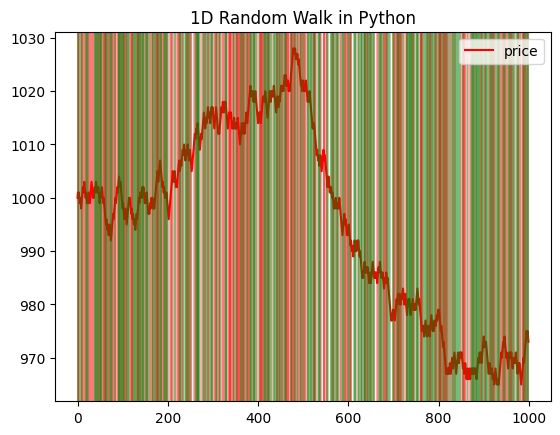

In [72]:
import matplotlib.pyplot as plt

total_total_reward=[]

timeline = []
price_history = []

env = CoinEnv(avr_m=0.1)
state = env.reset()
reward=0
current_time = 0
avr_history=[]
total_reward=[]

for _ in range(1000):
    timeline.append(current_time)
    price_history.append(state)
    action = env.action_space[np.random.randint(3)]
    # avr_history.append(np.mean(price_history))
    # if state<np.mean(price_history):
    #     action = env.action_space[1]
    # else:
    #     action = env.action_space[2]
    # action = env.action_space[0]
    state, reward, _, history = env.step(action, current_time)
    current_time += 1
    total_reward.append(reward)
for _ in env.history:
    total_reward.append(state)
print(" ".join(map(str, total_reward)))
print(f"avr: {np.mean(total_reward)}, max: {max(total_reward)}, min: {min(total_reward)}")

plt.plot(timeline, price_history, 'r-', label='price')
# plt.axhline(np.mean(price_history), label='Total Average')
# plt.plot(timeline, avr_history, label='Average')
a,b=False,False
for i in history['bought_time']:
    plt.axvline(i, color='red', alpha=0.3)
for i in history['sold_time']:
    plt.axvline(i, color='green', alpha=0.3)
plt.legend()
plt.title("1D Random Walk in Python")
plt.show()

In [20]:
class CoinEnv2:
    global test_case
    def __init__(self, start_price=1000, avr_m=0.5):
        self.action_space = [np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1])]
        self.start_price = start_price
        self.history=[]
        self.bought_time=[]
        self.sold_time=[]
        self.avr_m=avr_m

    def reset(self):
        self.state = self.start_price
        return self.state

    def step(self, action, current_time):
        current_price = self.state
        if action[1] and len(self.history)*self.avr_m<=30: # buy
            reward = -current_price
            self.history.append(current_price)
            self.bought_time.append(current_time)
        elif action[2] and len(self.history)*self.avr_m!=0: # sell
            reward = current_price
            self.history.remove(min(self.history))
            self.sold_time.append(current_time)
        else:
            reward = 0

        # direction = np.random.choice([-1, 1])
        direction=test_case[current_time]
        current_price += direction
        current_price=max(0, current_price)
        self.state = current_price
        

        # print(self.history)

        return self.state, reward, False, {'history': self.history, 'bought_time': self.bought_time, 'sold_time': self.sold_time}

In [ ]:
total_total_reward=[[] for i in range(5)]

In [56]:
total_total_reward.append([])

0 0 -1000 -999 -998 -997 -996 -995 -996 -995 -994 -993 -994 -995 -996 0 -996 0 -996 -995 -996 -995 -996 -995 -994 -993 -994 -993 -992 -991 -992 -991 -992 -991 -990 -989 -990 -989 -988 -987 -986 -987 -988 -989 -990 -989 -988 -987 -986 -987 -986 -987 -986 -985 -984 -983 -984 -983 -982 -983 -984 -985 -986 -987 -986 -987 -988 -989 -988 -987 -988 -989 -988 -987 -988 -989 -990 -989 -990 -989 -990 0 0 0 0 0 0 0 0 0 0 0 0 0 -990 -989 -988 -987 -986 -987 -986 -987 -988 -989 -988 -989 -988 -987 -988 -989 -988 -987 -988 -987 -986 -985 -984 -985 -984 -983 -982 -983 -982 -983 -982 -981 -982 -981 -982 -981 -982 -983 -982 -981 -982 -981 -980 -981 -982 -983 -982 -981 -980 -981 -980 -981 -980 -979 -980 -979 -980 -981 -982 -983 -982 -983 -984 -985 -986 -987 -986 -987 -986 -985 -984 -983 -984 -983 -982 -981 -980 -979 -980 -979 -978 -979 -980 -981 -980 -979 -978 -979 -980 -979 -978 -979 -980 -981 -982 -983 -984 -983 -982 -981 -982 -983 -984 -985 -984 -983 -984 -983 -984 -985 -986 0 0 0 -986 -985 -984 -985

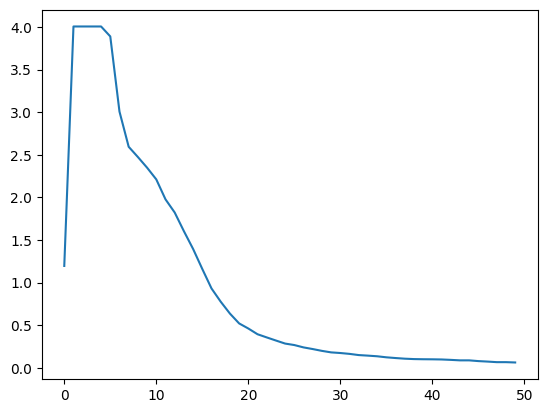

In [58]:
import matplotlib.pyplot as plt



for i in range(50):
    

    timeline = []
    price_history = []

    env = CoinEnv2(avr_m=i*0.02)
    state = env.reset()
    reward=0
    current_time = 0
    avr_history=[]
    total_reward=[]

    for _ in range(1000):
        timeline.append(current_time)
        price_history.append(state)
        # action = env.action_space[np.random.randint(3)]
        avr_history.append(np.mean(price_history))
        if state<np.mean(price_history):
            action = env.action_space[1]
        else:
            action = env.action_space[2]
        # action = env.action_space[0]
        state, reward, _, history = env.step(action, current_time)
        current_time += 1
        total_reward.append(reward)
    for _ in env.history:
        total_reward.append(state)
    print(" ".join(map(str, total_reward)))
    print(f"avr: {np.mean(total_reward)}, max: {max(total_reward)}, min: {min(total_reward)}")

    # plt.plot(timeline, price_history, 'r-', label='price')
    # # plt.axhline(np.mean(price_history), label='Total Average')
    # plt.plot(timeline, avr_history, label='Average')
    # a,b=False,False
    # for i in history['bought_time']:
    #     plt.axvline(i, color='red', alpha=0.3)
    # for i in history['sold_time']:
    #     plt.axvline(i, color='green', alpha=0.3)
    # plt.legend()
    # plt.title("1D Random Walk in Python")
    # plt.show()
    total_total_reward[5].append(np.mean(total_reward))

plt.plot(range(50), total_total_reward[5])
plt.show()

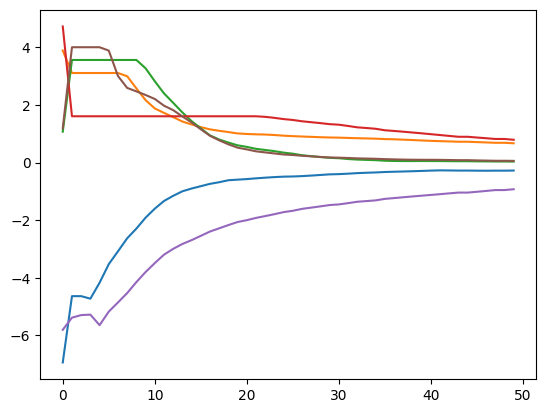

In [60]:
for i in range(6):
    plt.plot(range(50), total_total_reward[i])
plt.show()

In [35]:
total_total_reward

[-0.20389000670690813,
 1.4309687261632342,
 1.4309687261632342,
 1.4309687261632342,
 1.4309687261632342,
 1.4289008455034589,
 1.3333333333333333,
 1.2148148148148148,
 1.1885521885521886,
 1.1619537275064267,
 1.211120764552563,
 1.237467018469657,
 1.1873889875666075,
 1.103942652329749,
 1.0144404332129964,
 0.9309718437783833,
 0.8455210237659964,
 0.7759412304866851,
 0.7177121771217713,
 0.6506024096385542,
 0.6263940520446096,
 0.5951492537313433,
 0.5696913002806361,
 0.5337711069418386,
 0.4967074317968015,
 0.470311027332705,
 0.43950850661625707,
 0.42045454545454547,
 0.3956356736242884,
 0.37072243346007605,
 0.3577545195052331,
 0.334604385128694,
 0.30754536771728747,
 0.29349904397705545,
 0.28038277511961723,
 0.25119846596356665,
 0.23512476007677544,
 0.2219020172910663,
 0.20961538461538462,
 0.19826756496631376,
 0.1859344894026975,
 0.17647058823529413,
 0.16602316602316602,
 0.1565217391304348,
 0.1565217391304348,
 0.14796905222437137,
 0.13843175217812198,
 0

In [57]:
test_case=[np.random.choice([-1,1]) for i in range(1000)]
test_case

[1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,

In [10]:
test_case2=[]
for i in range(1000):
    if i==0:
        test_case2.append(0)
    else:
        test_case2.append(test_case[i]-test_case[i-1])

test_case2

[0,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 1,
 